# Prototype 01
## Experiment 01

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [4]:
# Validate that python 3.10 is used
!python --version

Python 3.10.10


In [5]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [6]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [7]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from prototypes.prototype_01.sensor_environment import SensorEnvironment
from prototypes.prototype_01.agent import Agent
from prototypes.prototype_01.client import Client
from prototypes.prototype_01.enums import Execution, Evaluation
from prototypes.prototype_01.server import Server
from prototypes.prototype_01.experiment import Experiment

ModuleNotFoundError: No module named 'prototypes'

## --- Hyperparameters ---

In [8]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.0001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4

## --- Source ---

In [9]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return stridesap

-----------
### Experiment 02
#### Part 01
How does the training behave when there are client-exclusive classes?

In [ ]:
import matplotlib.pyplot as plt

experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)
 
EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

behavior_subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
training_data_subset_1 = {x: training_data[x] for x in behavior_subset_1 if x in training_data}
environment_01 = SensorEnvironment(training_data_subset_1)

behavior_subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
training_data_subset_2 = {x: training_data[x] for x in behavior_subset_2 if x in training_data}
environment_02 = SensorEnvironment(training_data_subset_2)

datasets = {
    "Global Behavior Distribution": training_data, 
    "Behavior Distribution on Client 1": training_data_subset_1,
    "Behavior Distribution on Client 2": training_data_subset_2
}

for title, dataset in datasets.items():
    sample_distribution = {behavior: 0 for behavior in Behavior}
    for k, v in dataset.items():
         sample_distribution[k] = len(v)

    plt.bar(range(len(sample_distribution)), list(sample_distribution.values()), align='center', color='blue')
    plt.xticks(range(len(sample_distribution)), list(sample_distribution.keys()))
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel('n_samples')
    plt.savefig(f"{title}.jpg", bbox_inches="tight")
    plt.show()



global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

#server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.TIME], evaluation_frequency=1, verbose=True, document_results=True)

In [ ]:
for id in range(3):
    for behavior in Behavior:
        performance = server.client_performance[id][behavior]
        plt.title(f"Client {id}")
        plt.plot([*range(len(performance))], performance) # plotting t, a separately 
    plt.show()

In [ ]:
for behavior in Behavior:
    for id in range(3):
        performance = server.client_performance[id][behavior]
        plt.title(f"Behavior {behavior.value}")
        plt.ylim([0,100])
        if id == 0:
            plt.plot([*range(len(performance))], performance, linestyle='-') # plotting t, a separately 
        else:
            plt.plot([*range(len(performance))], performance, linestyle='--') # plotting t, a separately 
    plt.show()

-----------
### Experiment 02

In [125]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(training_data_strides[0])
environment_02 = SensorEnvironment(training_data_strides[1])

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


NameError: name 'stridesap' is not defined

In [52]:
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

sampling_probabilities = {
    Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.1,
    Behavior.ROOTKIT_BEURK: 0.2,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.2,
    Behavior.CNC_THETICK: 0.1, 
    Behavior.CNC_OPT1: 0.1,
    Behavior.CNC_OPT2: 0.1,
    Behavior.RANSOMWARE_POC: 0.2
}

environment = SensorEnvironment(training_data, sampling_probabilities)

sample_frequency = {}
for behavior in Behavior:
    # In the beginning no behavior has been drawn yet
    sample_frequency[behavior] = 0

for i in range(10000):
    sampled_attack = environment_01.sample_random_attack_from_distribution()[0]
    sampled_behavior = sampled_attack[-1]
    sample_frequency[sampled_behavior]+=1
    
for behavior, frequency in sample_frequency.items():
    print(f"{behavior}: {frequency}")

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
Behavior.NORMAL: 0
Behavior.ROOTKIT_BDVL: 1018
Behavior.ROOTKIT_BEURK: 2085
Behavior.CNC_BACKDOOR_JAKORITAR: 1955
Behavior.CNC_THETICK: 971
Behavior.CNC_OPT1: 1012
Behavior.CNC_OPT2: 1030
Behavior.RANSOMWARE_POC: 1929


In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 3
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=100

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
#training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)
environment_03 = SensorEnvironment(train_data)

from functools import reduce 

sample_distribution_percentages = {
    Behavior.NORMAL: 0,
    Behavior.RANSOMWARE_POC: 20,
    Behavior.ROOTKIT_BDVL: 10,
    Behavior.ROOTKIT_BEURK: 20,
    Behavior.CNC_THETICK: 10, 
    Behavior.CNC_BACKDOOR_JAKORITAR: 20,
    Behavior.CNC_OPT1: 10,
    Behavior.CNC_OPT2: 10
}

sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

In [134]:
#print(agent_01.total_accuracies)
#print(agent_02.total_accuracies)
print(f"Total Accuracies: {global_agent.total_accuracies}")

#print(agent_01.mean_class_accuracies)
#print(agent_02.mean_class_accuracies)
print(f"Mean Class Accuracies: {global_agent.mean_class_accuracies}")

Total Accuracies: {1: 0.7347519344560764, 2: 0.7531861629494766, 3: 0.7843650432407829, 4: 0.7968821119708693, 5: 0.8167956304050978, 6: 0.8224852071005917, 7: 0.8233955393718707, 8: 0.8282885753299954, 9: 0.8291989076012745, 10: 0.8299954483386436}
Mean Class Accuracies: {1: 0.7485073911314019, 2: 0.7691058885340596, 3: 0.8034764092325773, 4: 0.8173784225180111, 5: 0.8383226360892616, 6: 0.8414322701373222, 7: 0.8380457184022992, 8: 0.8442760356350558, 9: 0.8475243463420152, 10: 0.847519751098278}


-----------
### Experiment 2.1

In [31]:
import numpy as np

def multiclass_imbalance_degree(M):
    N = np.sum(M)
    n_cs = np.sum(M, axis=0)

    C = len(n_cs)
    MID = 0
    for n_c in n_cs:
        relative_label_frequency =  n_c / N
        MID+=relative_label_frequency*np.emath.logn(C, C*relative_label_frequency)   
    return round(MID, 4)

In [32]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def mean_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_two_norm = norm(L, 2)
    n = lis.shape[0]

    mean_cosine_similarity = 0
    for li in lis:
        mean_cosine_similarity += (1 / n) * (np.dot(L,li) / (L_two_norm * norm(li, 2)))

    return mean_cosine_similarity

In [33]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def weighted_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_one_norm = norm(L, 1)
    L_two_norm = norm(L, 2)
    #n = lis.shape[0]

    cosine_similarity = 0
    for li in lis:
        li_one_norm = norm(li, 1)
        li_two_norm = norm(li, 2)
        cosine_similarity +=  (li_one_norm/li_two_norm) * np.dot(L,li) 

    weighted_cosine_similarity = 1/(L_one_norm * L_two_norm)*cosine_similarity
    return round(weighted_cosine_similarity, 4)

#### 1. Scenario (MID = 0, WCS = 1)

In [145]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_SAMPLES = 10000
NR_EPISODES_PER_ROUND = int(math.ceil(NR_SAMPLES/NR_ROUNDS))

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

sampling_probabilities_1 = {
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

#sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
#assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"

environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.34 | ransomware_file_extension_hide |
| bdvl               |      98.32 | rootkit_sanitizer              |
| beurk              |      49.14 | rootkit_sanitizer              |
| the_tick           |      90.46 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      57.39 | cnc_ip_shuffle                 |
| data_leak_1        |      99.82 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
Agent 2 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      97.96 | ransomware_file_exte

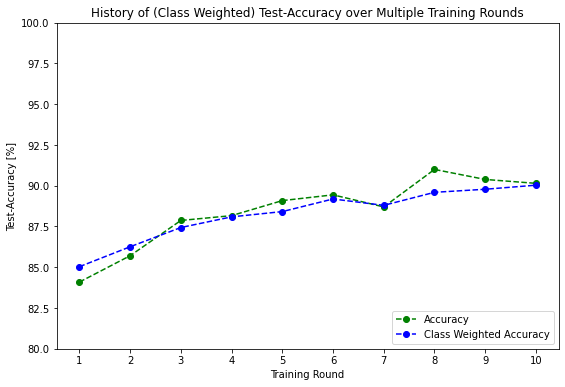

In [206]:
total_accuracies = {1: 0.8409194355939918, 2: 0.8570778334091943, 3: 0.878698224852071, 4: 0.8816568047337278, 5: 0.8908739189804279, 6: 0.894401456531634, 7: 0.8870050068274921, 8: 0.9099908966772872, 9: 0.9038461538461539, 10: 0.9014565316340464}
mean_class_accuracies: {1: 0.85034822776872, 2: 0.8625753762011524, 3: 0.8743673178765344, 4: 0.8809055365205404, 5: 0.8841368864332961, 6: 0.8918688862201104, 7: 0.8879642281327783, 8: 0.8959563865442828, 9: 0.8978331147231927, 10: 0.90032357514288}

rounds = list(total_accuracies.keys())

total_accuracies = np.array(list(total_accuracies))*100
mean_class_accuracies = np.array(list(mean_class_accuracies))*100

plt.figure(figsize=(9,6))
xlabel = "Training Round"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f"History of (Class Weighted) Test-Accuracy over Multiple Training Rounds")
plt.xticks(rounds)
plt.ylim(80, 100)

#print(f"Total Accuracies: {global_agent.total_accuracies}")
rounds = list(global_agent.total_accuracies.keys())
total_accuracies = np.array(list(global_agent.total_accuracies.values()))*100
#plt.plot(rounds, total_accuracies)
#print(f"Mean Class Accuracies: {global_agent.mean_class_accuracies}")
rounds = list(global_agent.mean_class_accuracies.keys())
mean_class_accuracies = np.array(list(global_agent.mean_class_accuracies.values()))*100
plt.plot(rounds, total_accuracies, marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(rounds, mean_class_accuracies, marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.legend(loc ="lower right")
plt.show()

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 3
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
#training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)
#environment_03 = SensorEnvironment(train_data)

from functools import reduce 

sample_distribution_percentages = {
    Behavior.NORMAL: 0,
    Behavior.RANSOMWARE_POC: 20,
    Behavior.ROOTKIT_BDVL: 10,
    Behavior.ROOTKIT_BEURK: 20,
    Behavior.CNC_THETICK: 10, 
    Behavior.CNC_BACKDOOR_JAKORITAR: 20,
    Behavior.CNC_OPT1: 10,
    Behavior.CNC_OPT2: 10
}

sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

#agent_03 = Agent(3, input_dims=environment_03.observation_space_size, n_actions=len(environment_03.actions), buffer_size=BUFFER_SIZE,
#                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)
#client_03 = Client(3, agent_03, environment_03, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)
#server.add_client(client_03)

server.run_federation(evaluations=[Evaluation.LEARNING_CURVE], evaluation_frequency=10)

Scenario 01 with MID: 0.0; WCS: 1.0


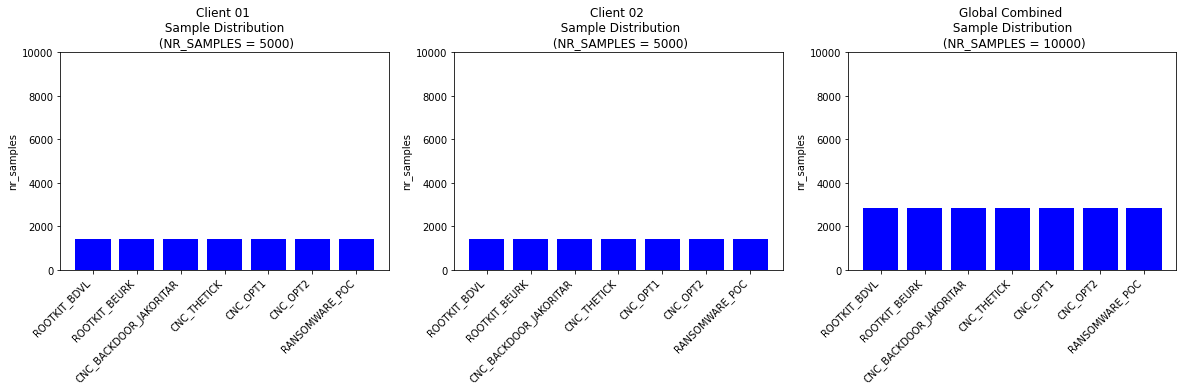

Scenario 02 with MID: 0.0505; WCS: 1.0


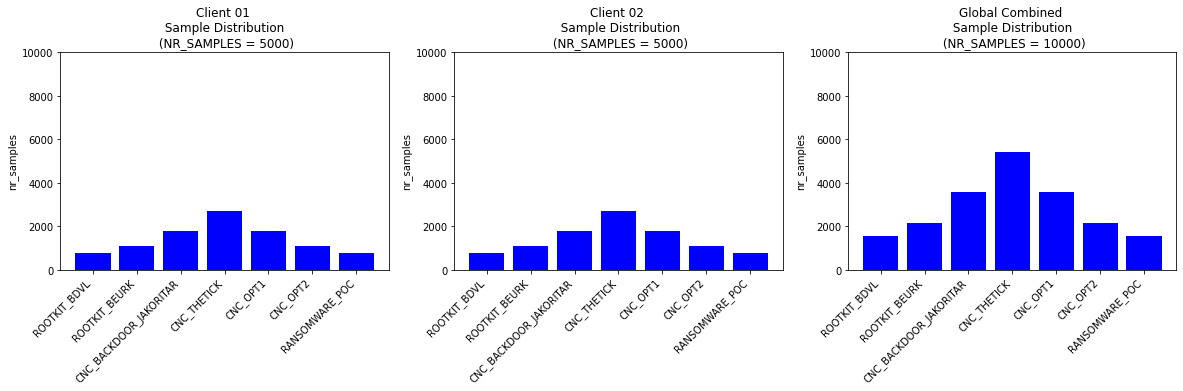

Scenario 03 with MID: 0.0; WCS: 0.9094


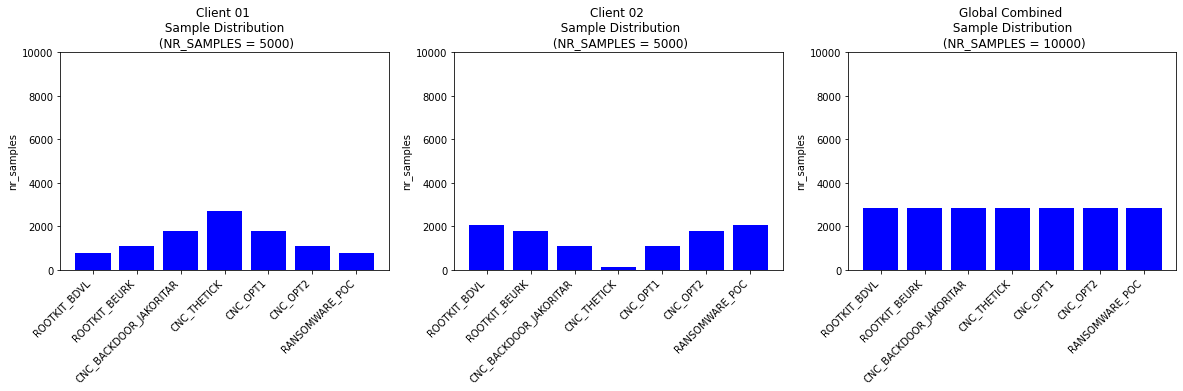

Scenario 04 with MID: 0.0128; WCS: 0.977


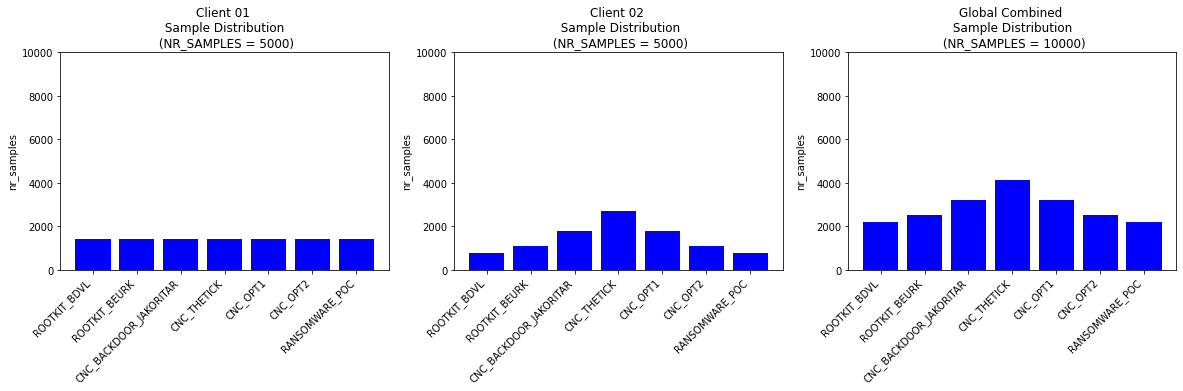

In [300]:
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce

fig = plt.gcf()
#fig.suptitle("Title centered above all subplots", fontsize=14)
plt.rcParams["figure.figsize"] = (20,4)

N_SAMPLES = 10000


unit_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

regular_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: (1/2 + 0.05) * 1/7,
    Behavior.ROOTKIT_BEURK: 3/4 * 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1.25 * 1/7,
    Behavior.CNC_THETICK: 1.9 * 1/7, 
    Behavior.CNC_OPT1: 1.25 * 1/7,
    Behavior.CNC_OPT2: 3/4 * 1/7,
    Behavior.RANSOMWARE_POC: (1/2 + 0.05) * 1/7
}

inverted_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1.45 * 1/7,
    Behavior.ROOTKIT_BEURK: 1.25 * 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 3/4 * 1/7,
    Behavior.CNC_THETICK: 0.1*1/7, 
    Behavior.CNC_OPT1: 3/4 * 1/7,
    Behavior.CNC_OPT2: 1.25 * 1/7,
    Behavior.RANSOMWARE_POC: 1.45 * 1/7
}

list_of_behaviors = list(map(lambda x: x.name, unit_sampling_probabilities.keys()))

for sampling_distribution in [unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities]:
    sum_of_percentages = round(reduce(lambda x, y: x+y, sampling_distribution.values()), 2)
    assert sum_of_percentages == 1, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"

combinations = [
    (unit_sampling_probabilities, unit_sampling_probabilities),
    (regular_sampling_probabilities, regular_sampling_probabilities),
    (regular_sampling_probabilities, inverted_sampling_probabilities),
    (unit_sampling_probabilities, regular_sampling_probabilities)
]

sample_frequency_combinations = []
sample_matrices = []

for combination in combinations:
    sampling_probabilities_1, sampling_probabilities_2 = combination
    
    n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
    n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES
    total_samples = n_samples_1 + n_samples_2
    
    sample_matrix = np.vstack([n_samples_1, n_samples_2])
    sample_matrices.append(sample_matrix)

    #print(f"MID: {multiclass_imbalance_degree(sample_matrix)}; WCS: {weighted_cosine_similarity(sample_matrix)}")

    sample_frequency_combinations.append({
        1: n_samples_1,
        2: n_samples_2,
        3: total_samples,
    })
       
titles = {
    1: "Client 01 \n Sample Distribution \n (NR_SAMPLES = 5000)",
    2: "Client 02 \n  Sample Distribution \n (NR_SAMPLES = 5000)",
    3: "Global Combined \n Sample Distribution \n (NR_SAMPLES = 10000)",
}

scenario_id = 1
for sample_frequencies in sample_frequency_combinations:
    sample_matrix = np.vstack([sample_frequencies[1], sample_frequencies[2]])
    print(f"Scenario 0{scenario_id} with MID: {multiclass_imbalance_degree(sample_matrix)}; WCS: {weighted_cosine_similarity(sample_matrix)}")
    
    scenario_id = scenario_id + 1
    
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.bar(range(len(sample_frequencies[i])), (sample_frequencies[i]), align='center', color='blue')
        plt.xticks(range(len(list_of_behaviors)), list_of_behaviors)
        plt.xticks(rotation=45, ha='right')
        plt.ylim([0, 10000])
        plt.title(titles[i])
        plt.ylabel('nr_samples')
    plt.show()


 Scenario 01 with MID: 0.0; WCS: 1.0



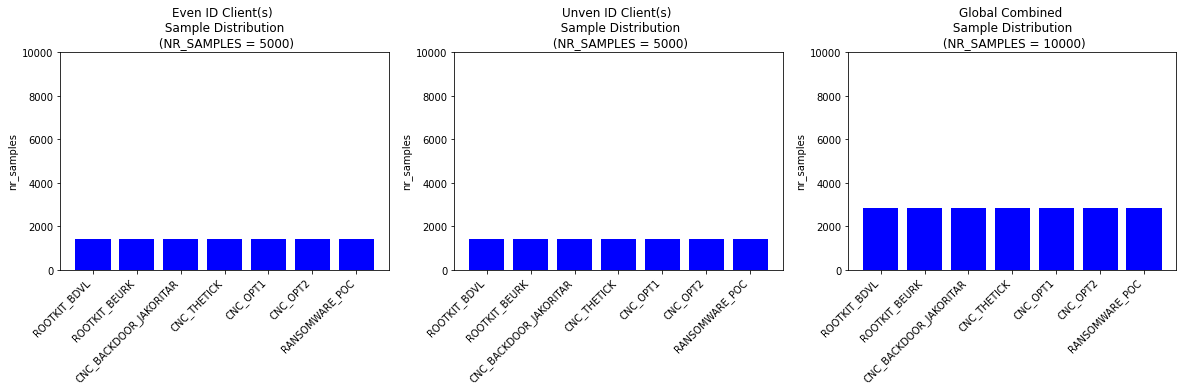


 Scenario 02 with MID: 0.0267; WCS: 1.0



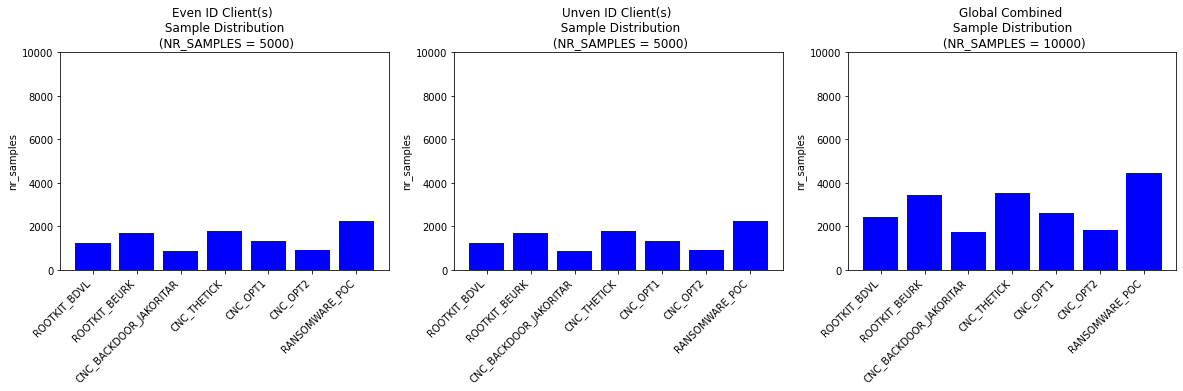


 Scenario 03 with MID: -0.0; WCS: 0.9516



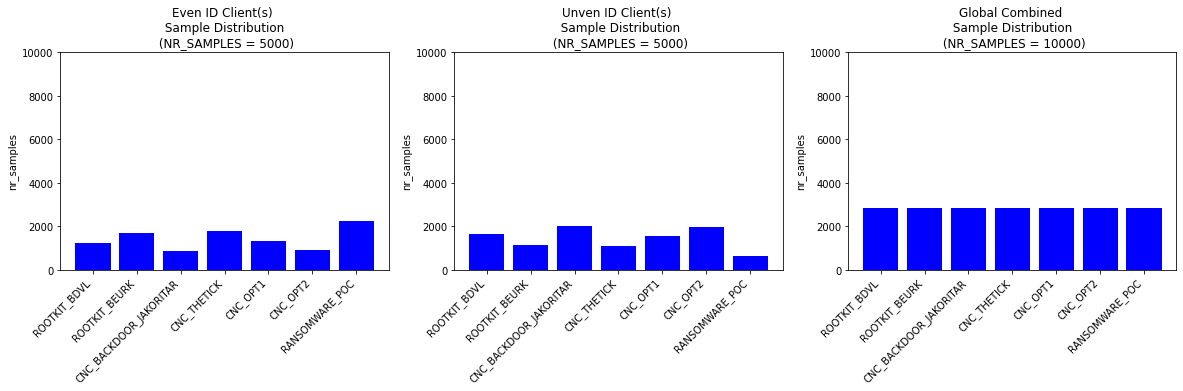


 Scenario 04 with MID: 0.0066; WCS: 0.9878



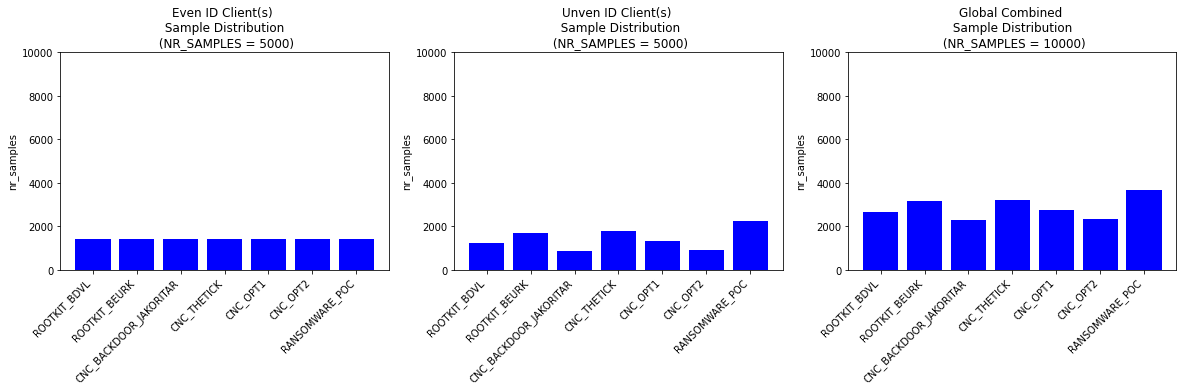


 Scenario 05 with MID: 0.0198; WCS: 0.9574



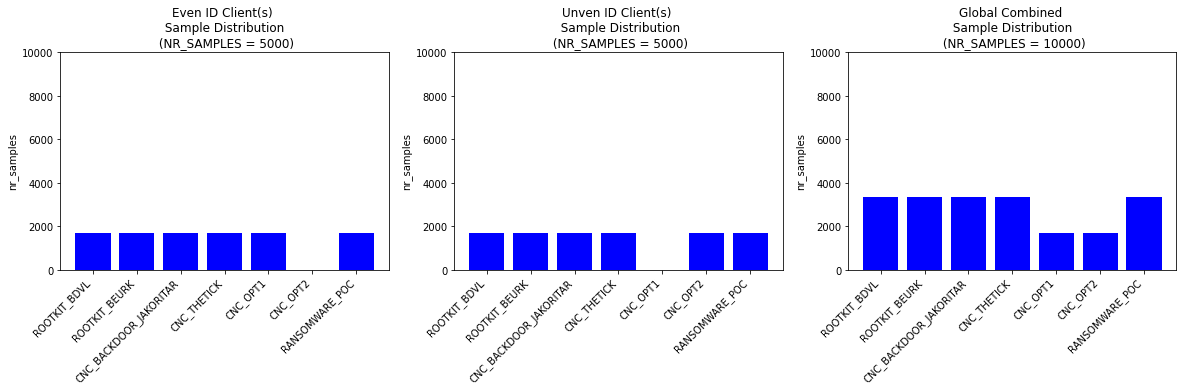


 Scenario 06 with MID: 0.0304; WCS: 0.8944



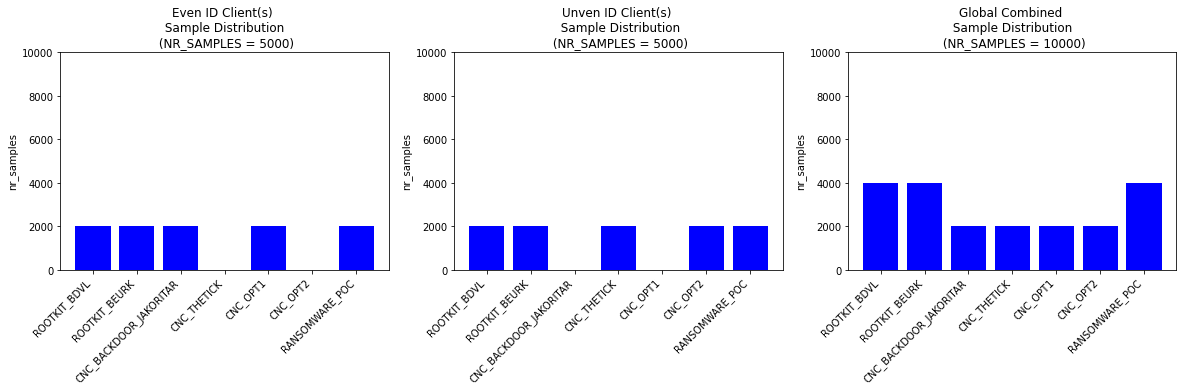


 Scenario 07 with MID: 0.0; WCS: 0.7125



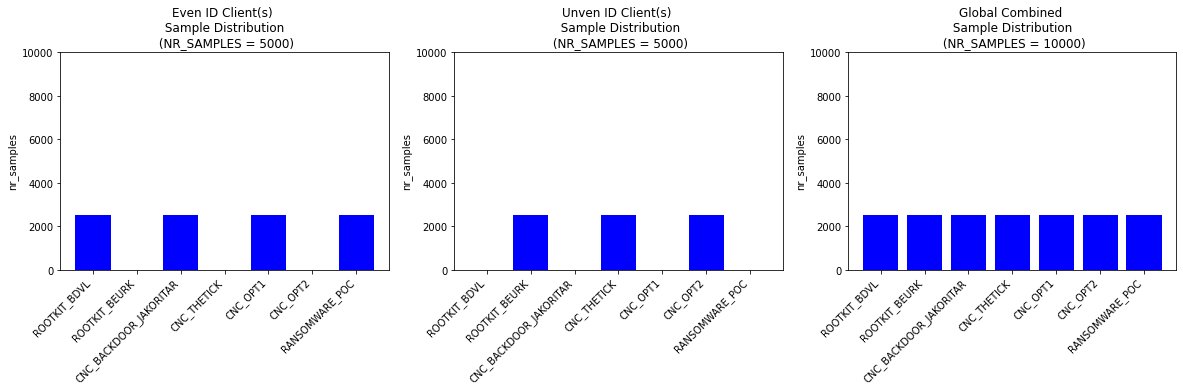

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from src.custom_types import Behavior
from src.functions import weighted_cosine_similarity, mean_cosine_similarity, multiclass_imbalance_degree, calculate_balance_metrics
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

from functools import reduce

fig = plt.gcf()
#fig.suptitle("Title centered above all subplots", fontsize=14)
plt.rcParams["figure.figsize"] = (20,4)

N_SAMPLES = 10000




list_of_behaviors = list(map(lambda x: x.name, unit_sampling_probabilities.keys()))

for sampling_distribution in [unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities]:
    sum_of_percentages = round(reduce(lambda x, y: x+y, sampling_distribution.values()), 2)
    assert sum_of_percentages == 1, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"

combinations = [
    (unit_sampling_probabilities, unit_sampling_probabilities),
    (regular_sampling_probabilities, regular_sampling_probabilities),
    (regular_sampling_probabilities, inverted_sampling_probabilities),
    (unit_sampling_probabilities, regular_sampling_probabilities),
    (weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02),
    (medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02),
    (strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02)
]

sample_frequency_combinations = []
sample_matrices = []

for combination in combinations:
    sampling_probabilities_1, sampling_probabilities_2 = combination
    
    n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
    n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES
    total_samples = n_samples_1 + n_samples_2
    
    sample_matrix = np.vstack([n_samples_1, n_samples_2])
    sample_matrices.append(sample_matrix)

    #print(f"MID: {multiclass_imbalance_degree(sample_matrix)}; WCS: {weighted_cosine_similarity(sample_matrix)}")

    sample_frequency_combinations.append({
        1: n_samples_1,
        2: n_samples_2,
        3: total_samples,
    })
       
titles = {
    1: "Even ID Client(s) \n Sample Distribution \n (NR_SAMPLES = 5000)",
    2: "Unven ID Client(s) \n  Sample Distribution \n (NR_SAMPLES = 5000)",
    3: "Global Combined \n Sample Distribution \n (NR_SAMPLES = 10000)",
}

scenario_id = 1
for sample_frequencies in sample_frequency_combinations:
    sample_matrix = np.vstack([sample_frequencies[1], sample_frequencies[2]])
    print(f"\n Scenario 0{scenario_id} with MID: {multiclass_imbalance_degree(sample_matrix)}; WCS: {weighted_cosine_similarity(sample_matrix)}\n")
    
    scenario_id = scenario_id + 1
    
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.bar(range(len(sample_frequencies[i])), (sample_frequencies[i]), align='center', color='blue')
        plt.xticks(range(len(list_of_behaviors)), list_of_behaviors)
        plt.xticks(rotation=45, ha='right')
        plt.ylim([0, 10000])
        plt.title(titles[i])
        plt.ylabel('nr_samples')
    plt.show()

In [20]:
np_sample_frequencies/np_sample_frequencies.sum(axis=0,keepdims=1)

array([0.22396998, 0.12248358, 0.17108016, 0.1766722 , 0.08348366,
       0.13125045, 0.09105996])

In [24]:
print(np_sample_frequencies)

[6208 3395 4742 4897 2314 3638 2524]


In [203]:
arr = np.array([1,2,3])
print(len(arr))
print(type(arr))
print(type(arr.tolist()))

3
<class 'numpy.ndarray'>
<class 'list'>


In [159]:
range(len(sampling_probabilities))

range(0, 7)

In [160]:
list(sampling_probabilities.keys())

[<Behavior.ROOTKIT_BDVL: 'bdvl'>,
 <Behavior.ROOTKIT_BEURK: 'beurk'>,
 <Behavior.CNC_BACKDOOR_JAKORITAR: 'backdoor_jakoritar'>,
 <Behavior.CNC_THETICK: 'the_tick'>,
 <Behavior.CNC_OPT1: 'data_leak_1'>,
 <Behavior.CNC_OPT2: 'data_leak_2'>,
 <Behavior.RANSOMWARE_POC: 'ransomware_poc'>]

In [ ]:
from numpy.linalg import norm

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
#print(mean_cosine_similarity(lis))

#### 2. Scenario (MID > 0, WCS = 1)

In [ ]:
import math

experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

seed_random()

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

N = 1000
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = int(math.ceil(N/NR_ROUNDS))

N_TOTAL = 10000
THRESHOLD = 2000
N_SAMPLES = N_TOTAL - THRESHOLD - 7
N_STRIDES = 15

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

final_training_accuracies = {}
final_mean_class_accuracies = {}

for i in range(N_STRIDES+1):
    fraction = N_SAMPLES/N_STRIDES
    majority = THRESHOLD + math.floor(i*fraction)+1
    minority = math.ceil((N_SAMPLES-i*fraction)/6)+1
    
    print(f"Majority: {majority}; Minority: {minority}")

    sample_matrix = np.array([[majority, minority, minority, minority, minority, minority, minority], [majority, minority, minority, minority, minority, minority, minority]])
    MID = multiclass_imbalance_degree(sample_matrix)
    WCS = weighted_cosine_similarity(sample_matrix)
    
    print(f"Training Dataset with MID: {MID} and WIS: {WCS}")
    
    sampling_probabilities = {
        Behavior.RANSOMWARE_POC: majority/N_TOTAL,
        Behavior.ROOTKIT_BDVL: minority/N_TOTAL,
        Behavior.ROOTKIT_BEURK: minority/N_TOTAL,
        Behavior.CNC_BACKDOOR_JAKORITAR: minority/N_TOTAL,
        Behavior.CNC_THETICK: minority/N_TOTAL, 
        Behavior.CNC_OPT1: minority/N_TOTAL,
        Behavior.CNC_OPT2: minority/N_TOTAL
    }
    
    environment_01 = SensorEnvironment(training_data, sampling_probabilities)
    environment_02 = SensorEnvironment(training_data, sampling_probabilities)

    global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    #print(NR_EPISODES_PER_ROUND)
    server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

    client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
    client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

    server.add_client(client_01)
    server.add_client(client_02)

    server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1, verbose=False)
    final_training_accuracy, final_mean_class_accuracy = server.final_training_accuracy()
    
    final_training_accuracies[MID] = final_training_accuracy
    final_mean_class_accuracies[MID] = final_mean_class_accuracy
    print(f"Final Training Accuracy: {final_training_accuracy}")
    print(f"Final Mean Class Accuracy: {final_mean_class_accuracy}")
    print("----------")

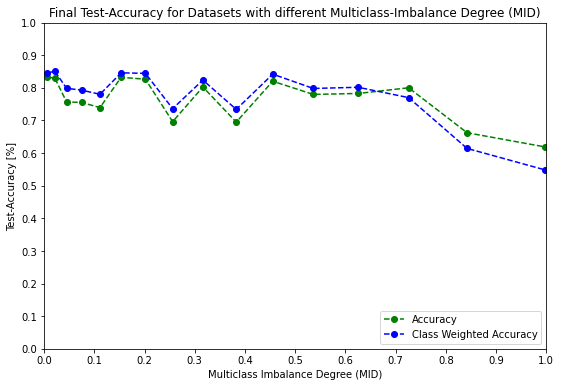

In [122]:
final_training_accuracies = {
    0.0062: 0.8338643604915794,
    0.0216: 0.8289713245334547,
    0.0448: 0.7571051433773327,
    0.0748: 0.7551706873008648,
    0.1113: 0.7395949021392808,
    0.1535: 0.832498862084661,
    0.2018: 0.8264679107874374,
    0.256: 0.6964087391898043,
    0.3162: 0.8026854802002731,
    0.3827: 0.6950295857988166,
    0.4553: 0.8204369594902139,
    0.536: 0.7799271734182976,
    0.6254: 0.7828857532999545,
    0.7259: 0.8002822030040965,
    0.8423: 0.6624578971324533,
    0.9969: 0.6191260810195721
 }

final_mean_class_accuracies = {
    0.0062: 0.8463411655330849,
    0.0216: 0.8503424371389757,
    0.0448: 0.7987394963125322,
    0.0748: 0.7929367758641254,
    0.1113: 0.7803693124076306,
    0.1535: 0.8461062129672096,
    0.2018: 0.8445162424465279,
    0.256: 0.7363210441661953,
    0.3162: 0.8238676090093533,
    0.3827: 0.7339862742852124,
    0.4553: 0.8420964154158485,
    0.536: 0.7981917404477847,
    0.6254: 0.8018314642749663,
    0.7259: 0.7701273877670419,
    0.8423: 0.6143420032537945,
    0.9969: 0.5487733017550455
}


plt.figure(figsize=(9,6))
xlabel = "Multiclass Imbalance Degree (MID)"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.plot(list(final_training_accuracies.keys()), list(final_training_accuracies.values()), marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(list(final_mean_class_accuracies.keys()), list(final_mean_class_accuracies.values()), marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc ="lower right")
plt.title(f"Final Test-Accuracy for Datasets with different Multiclass-Imbalance Degree (MID)")
plt.show()

#### 3. Scenario (MID = 0, WCS < 1)

In [84]:
from numpy.linalg import norm

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

final_training_accuracies = {}
final_mean_class_accuracies = {}

N = 1000
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = int(math.ceil(N/NR_ROUNDS))

N_SAMPLES = 10000

baseline_probability = 1/7
lowest_probability = 1/N_SAMPLES
n_strides = 10
frac = (baseline_probability - lowest_probability)/n_strides

for i in range(0, n_strides+1):
    baseline_deviation = i * frac
    inc_probability = baseline_probability + baseline_deviation
    dec_probability = baseline_probability - baseline_deviation
    print(f"i: {i}")
    print(f"inc_probability: {inc_probability}")
    print(f"dec_probability: {dec_probability}")

    sampling_probabilities_1 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: inc_probability,
        Behavior.ROOTKIT_BDVL: inc_probability,
        Behavior.ROOTKIT_BEURK: inc_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: dec_probability,
        Behavior.CNC_OPT2: dec_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: dec_probability,
    }

    sampling_probabilities_2 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: dec_probability, 
        Behavior.ROOTKIT_BDVL: dec_probability,
        Behavior.ROOTKIT_BEURK: dec_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: inc_probability,
        Behavior.CNC_OPT2: inc_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: inc_probability,
    }

    n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
    n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

    sample_matrix = np.vstack([n_samples_1, n_samples_2])
    
    MID = multiclass_imbalance_degree(sample_matrix)
    WCS = weighted_cosine_similarity(sample_matrix)

    print(f"MID: {MID}")
    print(f"WCS: {WCS}")
    
    environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
    environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

    global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    #print(NR_EPISODES_PER_ROUND)
    server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

    client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
    client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

    server.add_client(client_01)
    server.add_client(client_02)

    server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1, verbose=False)
    final_training_accuracy, final_mean_class_accuracy = server.final_training_accuracy()
    
    final_training_accuracies[WCS] = final_training_accuracy
    final_mean_class_accuracies[WCS] = final_mean_class_accuracy
    print(f"Final Training Accuracy: {final_training_accuracy}")
    print(f"Final Mean Class Accuracy: {final_mean_class_accuracy}")
    print("----------")

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
i: 0
inc_probability: 0.14285714285714285
dec_probability: 0.14285714285714285
MID: 0.0
WCS: 1.0
Final Training Accuracy: 0.8414883932635412
Final Mean Class Accuracy: 0.8535800693743356
----------
i: 1
inc_probability: 0.15713285714285713
dec_probability: 0.12858142857142857
MID: 0.0
WCS: 0.9957
Final Training Accuracy: 0.8359126081019572
Final Mean Class Accuracy: 0.8549514540206962
----------
i: 2
inc_probability: 0.1714085714285714
dec_probability: 0.11430571428571427
MID: 0.0
WCS: 0.9833
Final Training Accuracy: 0.8371643149749659
Final Mean Class Accuracy: 0.8476238420368423
----------
i: 3
inc_probability: 0.1856842857142857
dec_probability: 0.10003
MID: 0.0
WCS: 0.9636
Final Training Accuracy: 0.8373918980427856
Final Mean Class Accuracy: 0.8510202432786078
----------
i: 4
inc_probability: 0.19996
dec_probability: 0.0857542857142857
MID: 0.0
WCS: 0.9378
Final Training Accuracy: 0.627446517979062

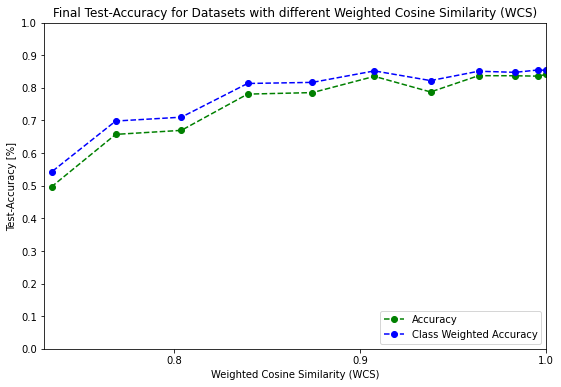

In [121]:
final_training_accuracies = {
    1.0: 0.8414883932635412,
    0.9957: 0.8359126081019572,
    0.9833: 0.8371643149749659,
    0.9636: 0.8373918980427856,
    0.9378: 0.7874465179790624,
    0.9076: 0.8353436504324079,
    0.8743: 0.7855120619025945,
    0.8394: 0.7808921256258535,
    0.8038: 0.6697086936731907,
    0.7685: 0.657419208010924,
    0.734: 0.49670004551661356
}

final_mean_class_accuracies = {
    1.0: 0.8535800693743356,
    0.9957: 0.8549514540206962,
    0.9833: 0.8476238420368423,
    0.9636: 0.8510202432786078,
    0.9378: 0.8223259371459675,
    0.9076: 0.852032852524513,
    0.8743: 0.8168542241714783,
    0.8394: 0.8134679960919038,
    0.8038: 0.7101254347289291,
    0.7685: 0.6983170899055311,
    0.734: 0.5421828417610298
}

plt.figure(figsize=(9,6))
xlabel = "Weighted Cosine Similarity (WCS)"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.plot(list(final_training_accuracies.keys()), list(final_training_accuracies.values()), marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(list(final_mean_class_accuracies.keys()), list(final_mean_class_accuracies.values()), marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.xlim([0.73,1])
plt.ylim([0, 1])
plt.legend(loc ="lower right")
plt.title(f"Final Test-Accuracy for Datasets with different Weighted Cosine Similarity (WCS)")
plt.show()

#### 4. Scenario (MID > 0, WCS < 1)

In [77]:
from numpy.linalg import norm

N_SAMPLES = 10000

sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.45,
    Behavior.ROOTKIT_BEURK: 0.45,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.0001,
    Behavior.CNC_THETICK: 0.0001, 
    Behavior.CNC_OPT1: 0.0001,
    Behavior.CNC_OPT2: 0.0001,
    Behavior.RANSOMWARE_POC: 0.0001
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.0001,
    Behavior.ROOTKIT_BEURK: 0.0001,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.45,
    Behavior.CNC_THETICK: 0.45, 
    Behavior.CNC_OPT1: 0.0001,
    Behavior.CNC_OPT2: 0.0001,
    Behavior.RANSOMWARE_POC: 0.0001
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

MID: 0.2861
WCS: 0.7073
